In [1729]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colors import white
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer


In [1730]:
features_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\preprocess\features.csv"
labels_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\preprocess\labels.csv"
features = pd.read_csv(features_path, delimiter = ";")
labels = pd.read_csv(labels_path, delimiter = ";")

In [1731]:
print('Features Columns:',features.columns[:])
print('Labels Columns:',labels.columns)

Features Columns: Index(['sample', 'wc_1', 'vm_1', 'fc_1', 'ac_1', 'c_1', 'h_1', 'o_1', 'n_1',
       's_1', 'cl_1', 'hc_1', 'oc_1', 'lhv_1', 'wc_2', 'vm_2', 'fc_2', 'ac_2',
       'c_2', 'h_2', 'o_2', 'n_2', 's_2', 'cl_2', 'hc_2', 'oc_2', 'lhv_2',
       'atmosphere', 'temperature', 'residence_time', 'pressure', 'heat_rate',
       'x_fuel1', 'x_fuel2'],
      dtype='object')
Labels Columns: Index(['sample', 'devol_yield'], dtype='object')


In [1732]:
wc = features['wc_1']*features['x_fuel1'] + features['wc_2']*features['x_fuel2']
vm = features['vm_1']*features['x_fuel1'] + features['vm_2']*features['x_fuel2']
fc = features['fc_1']*features['x_fuel1'] + features['fc_2']*features['x_fuel2']
ac = features['ac_1']*features['x_fuel1'] + features['ac_2']*features['x_fuel2']
c = features['c_1']*features['x_fuel1'] + features['c_2']*features['x_fuel2']
h = features['h_1']*features['x_fuel1'] + features['h_2']*features['x_fuel2']
o = features['o_1']*features['x_fuel1'] + features['o_2']*features['x_fuel2']
n = features['n_1']*features['x_fuel1'] + features['n_2']*features['x_fuel2']
s = features['s_1']* features['x_fuel1'] + features['s_2']*features['x_fuel2']
cl = features['cl_1']*features['x_fuel1'] + features['cl_2']*features['x_fuel2']
hc = features['hc_1']*features['x_fuel1'] + features['hc_2']*features['x_fuel2']
oc = features['oc_1']*features['x_fuel1'] + features['oc_2']*features['x_fuel2']
lhv = features['lhv_1']*features['x_fuel1'] + features['lhv_2']*features['x_fuel2']

In [1733]:
sum(lhv.isnull())

506

In [1734]:
features.shape

(2239, 34)

# Boie Equation
LHVd.b.(w) = 34,835 ∙ wC + 93,87 ∙ wH + 6,28 ∙ wN + 10,465 ∙ wS − 10,8 ∙ wO

In [1735]:
lhv= lhv.fillna((34.835*c+ 93.87*h + 6.28*n + 10.465*s - 10.8*o)/100, inplace=False)

In [1736]:
features = pd.concat([features['sample'],wc,vm,fc,ac,c,h,o,n,s,cl,hc,oc,lhv,features['temperature'], features['residence_time'], features['pressure'], features['heat_rate']], axis=1)
features.columns = ['sample','wc','vm','fc','ac','c','h','o','n','s','cl','hc','oc','lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate']


In [1737]:
features.iloc[2076]

sample               TC_122
wc                      5.6
vm                    46.19
fc                     44.5
ac                     3.76
c                     68.67
h                      4.17
o                      15.4
n                      2.21
s                      0.15
cl                      0.0
hc                      0.7
oc                      0.2
lhv               26.326859
temperature            1200
residence_time         10.0
pressure                1.0
heat_rate              1000
Name: 2076, dtype: object

In [1738]:
def classify_fuel(sample):
    sample = str(sample).lower()
    if "gumm" in sample or "gm" in sample:
        return "Rubber"
    elif "wod" in sample or 'wood' in sample or 'wd' in sample:
        return "Wood"
    elif "coal" in sample or 'bks' in sample:
        return "Lignite"
    elif "swage" in sample or 'swg' in sample or 'sewage' in sample:
        return "Sewage"
    elif "refuse" in sample or 'ref' in sample:
        return "RDF2"
    elif "digestate" in sample or 'dgst' in sample or "dgt" in sample:
        if all(x not in sample for x in ['pe', 'pp', 'car']):
            return "Digestate"
        elif "pe" in sample:
            return "Digestate_PE"
        elif "pp" in sample:
            return "Digestate_PP"
        elif "car" in sample:
            return "Digestate_SCP"
    elif "htc" in sample:
        return "HTC-MSW"
    elif "cel" in sample:
        return "Cellulose"
    elif "hc" in sample:
        return "Hemicellulose"
    elif "lig" in sample:
        return "Lignin"
    elif "ebs2" in sample:
        return "RDF2"
    elif "ebs1" in sample:
        return "RDF1"
    elif "tc_" in sample:
        return "Torr-Coal"
    elif "tw_" in sample:
        return "Torr-Wood"
    else:
        return "unknown"  # Default category

features['fuel_type'] = features['sample'].apply(classify_fuel)

print(pd.unique(features['fuel_type']))

['Lignite' 'Sewage' 'RDF2' 'Digestate' 'Wood' 'Digestate_PE'
 'Digestate_PP' 'Digestate_SCP' 'HTC-MSW' 'Cellulose' 'Hemicellulose'
 'Lignin' 'RDF1' 'Rubber' 'Torr-Coal' 'Torr-Wood']


In [1739]:
def classify_category(fuel_type):
    fuel_type = str(fuel_type)
    if "Rubber" in fuel_type:
        return "Plastic"
    elif 'Wood' in fuel_type:
        return "Biomass"
    elif "Lignite" in fuel_type:
        return "Coal"
    elif 'Sewage' in fuel_type:
        return "Biomass"
    elif "RDF2" in fuel_type:
        return "Plastic"
    elif "Digestate" in fuel_type:
        if all(x not in fuel_type for x in ['PE', 'PP', 'SCP']):
            return "Biomass"
        elif "PE" in fuel_type:
            return "Mix"
        elif "PP" in fuel_type:
            return "Mix"
        elif "SCP" in fuel_type:
            return "Mix"
    elif "HTC-MSW" in fuel_type:
        return "Biomass"
    elif "Cellulose" in fuel_type:
        return "Biomass"
    elif "Hemicellulose" in fuel_type:
        return "Biomass"
    elif "Lignin" in fuel_type:
        return "Biomass"
    elif "RDF1" in fuel_type:
        return "Plastic"
    elif "Torr-Coal" in fuel_type:
        return "Coal"
    elif "Torr-Wood" in fuel_type:
        return "Biomass"
    elif "RDF2" in fuel_type:
        return "Plastic"
    else:
        return "-"  # Default category

features['fuel_category'] = features['fuel_type'].apply(classify_category)
print(pd.unique(features['fuel_category']))



['Coal' 'Biomass' 'Plastic' 'Mix']


In [1740]:
data = pd.concat([features, labels['devol_yield']], axis=1)
data[data['devol_yield']>0].shape
data[data['devol_yield']>0].to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data.csv", index=False)

In [1741]:
counts = data[data['devol_yield'] > 0]['fuel_type'].value_counts().reset_index()
counts.columns = ['fuel_type', 'count']
counts['fuel_category'] = counts['fuel_type'].apply(classify_category)
print(counts)

        fuel_type  count fuel_category
0          Sewage    241       Biomass
1       Digestate    236       Biomass
2            Wood    236       Biomass
3   Digestate_SCP    206           Mix
4         Lignite    195          Coal
5    Digestate_PP    183           Mix
6    Digestate_PE    174           Mix
7            RDF2    137       Plastic
8         HTC-MSW    134       Biomass
9       Torr-Coal    128          Coal
10      Torr-Wood    121       Biomass
11           RDF1     62       Plastic
12         Rubber     56       Plastic
13  Hemicellulose     44       Biomass
14         Lignin     44       Biomass
15      Cellulose     39       Biomass


In [1742]:
data.head()

,sample,wc,vm,fc,ac,c,h,o,n,s,...,hc,oc,lhv,temperature,residence_time,pressure,heat_rate,fuel_type,fuel_category,devol_yield
0,brown_coal_1,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,...,0.7,0.2,20.13,600,0.5,1.0,1000,Lignite,Coal,3.437227
1,brown_coal_2,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,...,0.7,0.2,20.13,600,0.5,1.0,1000,Lignite,Coal,3.163017
2,brown_coal_3,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,...,0.7,0.2,20.13,600,0.5,1.0,1000,Lignite,Coal,4.827940
3,brown_coal_4,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,...,0.7,0.2,20.13,600,0.5,1.0,1000,Lignite,Coal,4.509894
4,brown_coal_5,10.8,44.2,40.9,4.2,63.4,3.9,16.2,0.9,0.6,...,0.7,0.2,20.13,600,1.0,1.0,1000,Lignite,Coal,4.128819


In [1743]:

# Assuming df is your DataFrame
columns_of_interest = ['temperature', 'heat_rate', 'pressure', 'residence_time', 'devol_yield']

# Group by fuel_type and calculate min and max
ranges = data.groupby('fuel_type')[columns_of_interest].agg(['min', 'max'])

# Optional: flatten the column MultiIndex
ranges.columns = ['_'.join(col).strip() for col in ranges.columns.values]

# Reset index if you want 'fuel_type' as a column
ranges = ranges.reset_index()

print(ranges)

pd.DataFrame(ranges)


        fuel_type  temperature_min  temperature_max  heat_rate_min  \
0       Cellulose              200             1200           1000   
1       Digestate              400             1200             10   
2    Digestate_PE              400             1200           1000   
3    Digestate_PP              400             1200           1000   
4   Digestate_SCP              400             1200           1000   
5         HTC-MSW              200             1200             10   
6   Hemicellulose              200             1200           1000   
7          Lignin              200             1200           1000   
8         Lignite              400             1200             10   
9            RDF1              400             1200             10   
10           RDF2              400             1180             10   
11         Rubber              400             1200             10   
12         Sewage              400             1200             10   
13      Torr-Coal   

,fuel_type,temperature_min,temperature_max,heat_rate_min,heat_rate_max,pressure_min,pressure_max,residence_time_min,residence_time_max,devol_yield_min,devol_yield_max
0,Cellulose,200,1200,1000,1000,1.0,1.0,0.5,20.0,-2.871983,99.756944
1,Digestate,400,1200,10,1000,0.5,20.0,0.5,20.0,6.365314,80.299786
2,Digestate_PE,400,1200,1000,1000,1.0,20.0,0.5,10.0,5.234657,84.896715
3,Digestate_PP,400,1200,1000,1000,1.0,20.0,0.5,10.0,1.457726,79.476861
4,Digestate_SCP,400,1200,1000,1000,1.0,20.0,0.5,10.0,8.680556,72.999304
5,HTC-MSW,200,1200,10,1000,1.0,20.0,0.5,10.0,2.878561,66.452304
6,Hemicellulose,200,1200,1000,1000,1.0,1.0,0.5,20.0,0.606673,95.932346
7,Lignin,200,1200,1000,1000,1.0,1.0,0.5,20.0,1.797080,70.907791
8,Lignite,400,1200,10,1000,1.0,20.0,0.5,10.0,1.965318,82.190787
9,RDF1,400,1200,10,1000,0.5,10.0,1.0,20.0,11.432707,94.716775


  fuel_category  count
0       Biomass   1095
1           Mix    563
2          Coal    323
3       Plastic    255


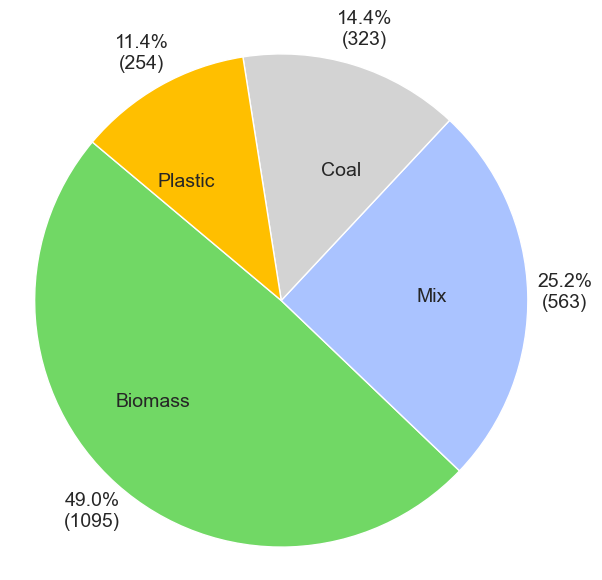

In [1744]:
import matplotlib.pyplot as plt

# Count fuel categories with devol_yield > 0
category_counts = data[data['devol_yield'] > 0]['fuel_category'].value_counts().reset_index()
category_counts.columns = ['fuel_category', 'count']
print(category_counts)

# Function for custom labels
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plotting
plt.figure(figsize=(7, 7))
plt.pie(
    category_counts['count'],
    labels=category_counts['fuel_category'],
    autopct=lambda pct: func(pct, category_counts['count']),
       pctdistance=1.15, labeldistance=.55,
    startangle=140,  colors = ['#71d865', '#aac3ff', '#d3d3d3', '#FFBF00'],  textprops={'fontsize': 14}
)
plt.axis('equal')
plt.show()




C:\Users\demir\AppData\Local\Temp\ipykernel_8032\1877686418.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\demir\AppData\Local\Temp\ipykernel_8032\1877686418.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\demir\AppData\Local\Temp\ipykernel_8032\1877686418.py:41: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  boxplot = sns.boxplot(
C:\Users\demir\AppData\Local\Temp\ipykernel_8032\1877686418.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for

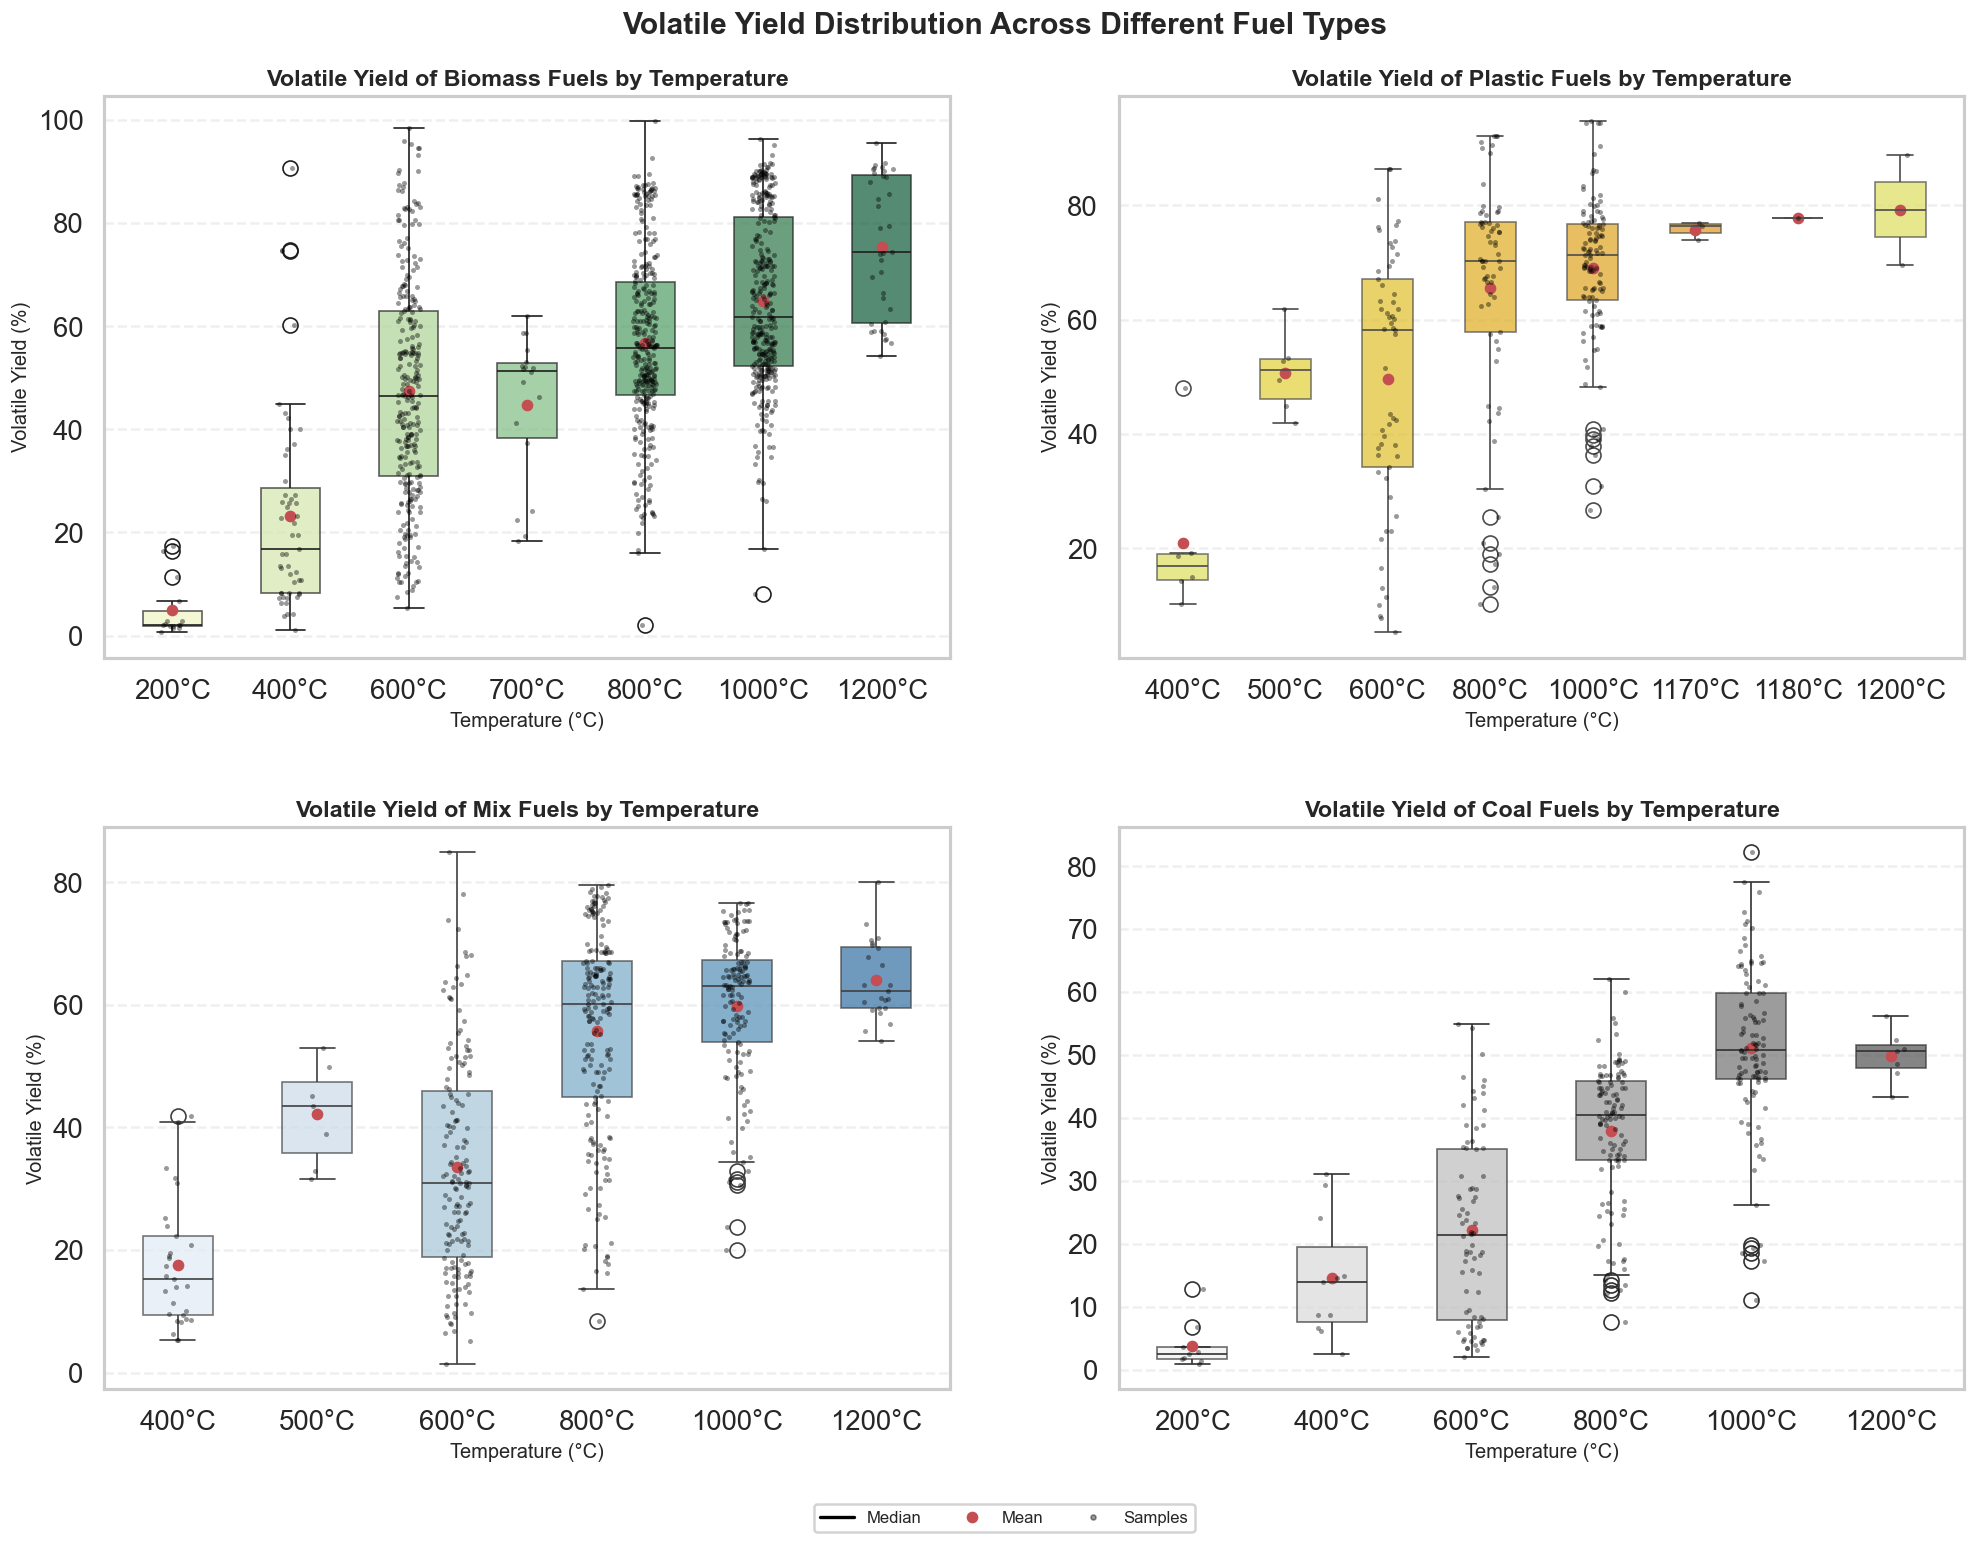

In [1745]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Filter out any negative or zero values
data = data[data['devol_yield'] > 0]
total = data
# Set the aesthetic style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Define fuel categories and their corresponding color palettes
fuel_categories = ['Biomass', 'Plastic', 'Mix', 'Coal']
color_palettes = ['YlGn', 'Wistia', 'Blues', 'Greys']

# Create figure with GridSpec for better control
fig = plt.figure(figsize=(20, 14), dpi=120)
gs = GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.3)

# Create a dictionary to store legend elements
legend_elements = []

# Loop through each fuel category and create a subplot
for i, (fuel, palette) in enumerate(zip(fuel_categories, color_palettes)):
    # Calculate subplot position
    row, col = i // 2, i % 2
    ax = fig.add_subplot(gs[row, col])

    # Skip if no data for this fuel category
    if len(data[data['fuel_category'] == fuel]) == 0:
        ax.text(0.5, 0.5, f"No data available for {fuel}",
                ha='center', va='center', transform=ax.transAxes)
        continue

    # Define colors for this subplot
    colors = sns.color_palette(palette, n_colors=7)

    # Create the boxplot
    boxplot = sns.boxplot(
        data=data[data['fuel_category'] == fuel],
        x='temperature',
        y='devol_yield',
        palette=colors,
        width=0.5,
        boxprops={'alpha': 0.7},
        ax=ax
    )

    # Add individual data points
    stripplot = sns.stripplot(
        data=data[data['fuel_category'] == fuel],
        x='temperature',
        y='devol_yield',
        color='black',
        alpha=0.4,
        size=3,
        jitter=True,
        ax=ax
    )

    # Add mean value markers
    temp_values = sorted(data[data['fuel_category'] == fuel]['temperature'].unique())
    for j, temp in enumerate(temp_values):
        temp_data = data[(data['fuel_category'] == fuel) & (data['temperature'] == temp)]
        if len(temp_data) > 0:  # Make sure we have data points
            mean_yield = temp_data['devol_yield'].mean()
            mean_point = ax.plot(j, mean_yield, 'ro', markersize=6)[0]

    # Customize labels and title
    ax.set_title(f'Volatile Yield of {fuel} Fuels by Temperature', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatile Yield (%)', fontsize=12)
    ax.set_xlabel('Temperature (°C)', fontsize=12)

    # Customize x-axis labels
    if len(temp_values) > 0:
        ax.set_xticks(range(len(temp_values)))
        ax.set_xticklabels([f'{t}°C' for t in temp_values])

    # Add subtle grid
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Create legend elements for this subplot if it's the first one
    if i == 0:
        median_line = plt.Line2D([0], [0], color='black', label='Median', lw=2)
        mean_point = plt.Line2D([0], [0], marker='o', color='r', label='Mean',
                             markerfacecolor='r', markersize=6, linestyle='')
        outlier_point = plt.Line2D([0], [0], marker='o', color='black', label='Samples',
                              markerfacecolor='black', markersize=3, alpha=0.4, linestyle='')

        legend_elements = [median_line, mean_point, outlier_point]

# Add a common legend at the bottom of the figure
fig.legend(handles=legend_elements,
          loc='lower center',
          ncol=4,
          frameon=True,
          framealpha=0.85,
          fontsize=10,
          bbox_to_anchor=(0.5, 0.02))

# Add an overall title for the entire figure
fig.suptitle('Volatile Yield Distribution Across Different Fuel Types',
             fontsize=18, fontweight='bold', y=0.93)

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.96])  # Make room for overall title and bottom legend

plt.savefig('multi_fuel_tile_plot.png', dpi=200, bbox_inches='tight')
plt.show()

In [1746]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.contingency_tables import mcnemar
from collections import defaultdict

# --- Z-Score Outlier Removal ---
def remove_outliers_z_score(df, threshold=1):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        z_scores = stats.zscore(group['devol_yield'])
        group = group.copy()
        group['isOutlierZ'] = np.abs(z_scores) > threshold
        result.append(group)
    return pd.concat(result)

# --- Modified Z-Score Outlier Removal ---
def remove_outliers_modified_z_score(df, threshold=1):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        median = group['devol_yield'].median()
        mad = np.median(np.abs(group['devol_yield'] - median))
        if mad == 0:
            modified_z = np.zeros_like(group['devol_yield'])
        else:
            modified_z = 0.6745 * (group['devol_yield'] - median) / mad
        group = group.copy()
        group['isOutlierModZ'] = np.abs(modified_z) > threshold
        result.append(group)
    return pd.concat(result)

# --- Median Absolute Deviation (MAD) Outlier Removal ---
def remove_outliers_mad(df, threshold=1):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        median = group['devol_yield'].median()
        mad = np.median(np.abs(group['devol_yield'] - median))
        outliers = np.abs(group['devol_yield'] - median) > threshold * mad
        group = group.copy()
        group['isOutlierMAD'] = outliers
        result.append(group)
    return pd.concat(result)

# --- IQR Outlier Removal ---
def remove_outliers_iqr(df, threshold=1.5):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        Q1 = group['devol_yield'].quantile(0.25)
        Q3 = group['devol_yield'].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (group['devol_yield'] < (Q1 - threshold * IQR)) | (group['devol_yield'] > (Q3 + threshold * IQR))
        group = group.copy()
        group['isOutlierIQR'] = outliers
        result.append(group)
    return pd.concat(result)

# --- Compare outlier detection methods ---
def compare_outlier_methods(df):
    temps = sorted(df['temperature'].unique())
    method_stats = []

    for temp in temps:
        temp_df = df[df['temperature'] == temp]

        original_values = temp_df['devol_yield'].tolist()

        z_filtered = temp_df[~temp_df['isOutlierZ']]['devol_yield'].tolist()
        mod_z_filtered = temp_df[~temp_df['isOutlierModZ']]['devol_yield'].tolist()
        mad_filtered = temp_df[~temp_df['isOutlierMAD']]['devol_yield'].tolist()
        iqr_filtered = temp_df[~temp_df['isOutlierIQR']]['devol_yield'].tolist()

        z_outliers = temp_df[temp_df['isOutlierZ']]['devol_yield'].tolist()
        mod_z_outliers = temp_df[temp_df['isOutlierModZ']]['devol_yield'].tolist()
        mad_outliers = temp_df[temp_df['isOutlierMAD']]['devol_yield'].tolist()
        iqr_outliers = temp_df[temp_df['isOutlierIQR']]['devol_yield'].tolist()

        method_stats.append({
            'temperature': temp,
            'originalCount': len(original_values),
            'zOutlierCount': len(z_outliers),
            'modZOutlierCount': len(mod_z_outliers),
            'madOutlierCount': len(mad_outliers),
            'iqrOutlierCount': len(iqr_outliers),
            'originalMean': np.mean(original_values),
            'zFilteredMean': np.mean(z_filtered) if z_filtered else 0,
            'modZFilteredMean': np.mean(mod_z_filtered) if mod_z_filtered else 0,
            'madFilteredMean': np.mean(mad_filtered) if mad_filtered else 0,
            'iqrFilteredMean': np.mean(iqr_filtered) if iqr_filtered else 0,
            'originalMedian': np.median(original_values),
            'zFilteredMedian': np.median(z_filtered) if z_filtered else 0,
            'modZFilteredMedian': np.median(mod_z_filtered) if mod_z_filtered else 0,
            'madFilteredMedian': np.median(mad_filtered) if mad_filtered else 0,
            'iqrFilteredMedian': np.median(iqr_filtered) if iqr_filtered else 0,
            'originalStd': np.std(original_values),
            'zFilteredStd': np.std(z_filtered) if z_filtered else 0,
            'modZFilteredStd': np.std(mod_z_filtered) if mod_z_filtered else 0,
            'madFilteredStd': np.std(mad_filtered) if mad_filtered else 0,
            'iqrFilteredStd': np.std(iqr_filtered) if iqr_filtered else 0,
        })

    return method_stats

# --- Statistical test for method differences ---
# --- Normality test for method differences ---
# --- Wilcoxon Signed-Rank Test for method differences ---
def test_significance(stats_list):
    z_means = [s['zFilteredMean'] for s in stats_list]
    mod_z_means = [s['modZFilteredMean'] for s in stats_list]
    mad_means = [s['madFilteredMean'] for s in stats_list]
    iqr_means = [s['iqrFilteredMean'] for s in stats_list]

    # Calculate the paired differences
    stat_results = {
        'z_vs_modZ': stats.wilcoxon(z_means, mod_z_means, zero_method='wilcox'),
        'z_vs_mad': stats.wilcoxon(z_means, mad_means, zero_method='wilcox'),
        'z_vs_iqr': stats.wilcoxon(z_means, iqr_means, zero_method='wilcox'),
        'modz_vs_iqr': stats.wilcoxon(mod_z_means, iqr_means, zero_method='wilcox'),
        'mad_vs_iqr': stats.wilcoxon(mad_means, iqr_means, zero_method='wilcox'),
        'modZ_vs_mad': stats.wilcoxon(mod_z_means, mad_means, zero_method='wilcox')
    }

    # Format results
    formatted_results = {
        key: {'W_statistic': res.statistic, 'p_value': res.pvalue}
        for key, res in stat_results.items()
    }

    return formatted_results



# --- Agreement metrics ---
def calculate_agreement(df):
    total_points = len(df)
    agreement_count_z_modz = (df['isOutlierZ'] == df['isOutlierModZ']).sum()
    agreement_count_z_mad = (df['isOutlierZ'] == df['isOutlierMAD']).sum()
    agreement_count_z_iqr = (df['isOutlierZ'] == df['isOutlierIQR']).sum()

    return {
        'agreement_count_z_modz': agreement_count_z_modz,
        'agreement_count_z_mad': agreement_count_z_mad,
        'agreement_count_z_iqr': agreement_count_z_iqr,
    }

# --- Main Pipeline ---
def main():
    # Dummy örnek (yerine kendi verini koymalısın)
    data = total  # <- `total` burada bir pandas DataFrame olmalı
    df = pd.DataFrame(data)

    # Apply outlier detection methods
    df = remove_outliers_z_score(df)
    df = remove_outliers_modified_z_score(df)
    df = remove_outliers_mad(df)
    df = remove_outliers_iqr(df)

    # Compare methods
    comparison_stats = compare_outlier_methods(df)
    comparison_df = pd.DataFrame(comparison_stats)

    # Significance testing
    significance = test_significance(comparison_stats)

    # Agreement metrics
    agreement = calculate_agreement(df)

    # Print results
    print("--- Comparison Stats ---")
    print(comparison_df)

    print("\n--- Significance Test ---")
    print(significance)

    print("\n--- Agreement Metrics ---")
    print(agreement)

    # Save comparison stats to CSV
    comparison_df.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Figures & Tables\comparison_stats.csv", index=False)
if __name__ == "__main__":
    main()


--- Comparison Stats ---
   temperature  originalCount  zOutlierCount  modZOutlierCount  \
0          200             24             10                 5   
1          400             97             31                29   
2          500             13              6                 4   
3          600            575            196               163   
4          700             18              7                 7   
5          800            721            191               230   
6         1000            716            179               226   
7         1170              3              1                 1   
8         1180              1              0                 0   
9         1200             68             20                21   

   madOutlierCount  iqrOutlierCount  originalMean  zFilteredMean  \
0                9                2      4.474632       3.363295   
1               44                7     20.358987      17.344531   
2                5                0     46.0

In [1747]:
def remove_outliers_modified_z_score(df, threshold=1):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        median = group['devol_yield'].median()
        mad = np.median(np.abs(group['devol_yield'] - median))
        if mad == 0:
            modified_z = np.zeros_like(group['devol_yield'])
        else:
            modified_z = 0.6745 * (group['devol_yield'] - median) / mad
        group = group.copy()
        group['isOutlierModZ'] = np.abs(modified_z) > threshold
        group = group[~group['isOutlierModZ']]  # remove outliers
        result.append(group)
    return pd.concat(result).drop(columns='isOutlierModZ')


def remove_outliers_mad(df, threshold=1):
    result = []
    for temp, group in df.groupby(['temperature', 'fuel_type']):
        median = group['devol_yield'].median()
        mad = np.median(np.abs(group['devol_yield'] - median))
        outliers = np.abs(group['devol_yield'] - median) > threshold * mad
        group = group.copy()
        group['isOutlierMAD'] = outliers
        group = group[~group['isOutlierMAD']]  # remove outliers
        result.append(group)
    return pd.concat(result).drop(columns='isOutlierMAD')


In [1748]:
filtered_features = remove_outliers_modified_z_score(total)
print(f'Samples: {total.shape}')
print(f'Samples After Outlier Removal: {filtered_features.shape}')

Samples: (2236, 21)
Samples After Outlier Removal: (1550, 21)


In [1749]:

biomass_filtered = filtered_features[filtered_features['fuel_category'] == 'Biomass']
mix_filtered = filtered_features[filtered_features['fuel_category'] == 'Mix']
coal_filtered = filtered_features[filtered_features['fuel_category'] == 'Coal']
plastic_filtered = filtered_features[filtered_features['fuel_category'] == 'Plastic']

In [1750]:
filtered_features.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered.csv")

In [1751]:
mix_filtered.shape

(398, 21)

In [1752]:
biomass_filtered.columns

Index(['sample', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate',
       'fuel_type', 'fuel_category', 'devol_yield'],
      dtype='object')

In [1753]:
biomass_filtered.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\biomass_filtered.csv")
mix_filtered.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\mixed_filtered.csv")
coal_filtered.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\coal_filtered.csv")
plastic_filtered.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\plastic_filtered.csv")

In [1754]:
print(pd.unique(plastic_filtered['fuel_type']))
print(pd.unique(mix_filtered['fuel_type']))

['RDF1' 'RDF2' 'Rubber']
['Digestate_PE' 'Digestate_PP' 'Digestate_SCP']


In [1755]:
# Count after outlier removal
after_counts = filtered_features['fuel_type'].value_counts().reset_index()
after_counts.columns = ['fuel_type', 'After Outlier Removal']

# Merge before and after counts
merged_counts = counts.merge(after_counts, on='fuel_type', how='left')

# Fill NaNs in case some fuel types were entirely removed
merged_counts['After Outlier Removal'] = merged_counts['After Outlier Removal'].fillna(0).astype(int)

# Add Loss column
merged_counts['Loss'] = merged_counts['count'] - merged_counts['After Outlier Removal']

# Add fuel_category temporarily
merged_counts['fuel_category_temp'] = merged_counts['fuel_type'].apply(classify_category)

# Reorder columns: keep existing, move fuel_category to the end
cols = [col for col in merged_counts.columns if col != 'fuel_category_temp'] + ['fuel_category_temp']
merged_counts = merged_counts[cols]

# Rename to proper name
merged_counts.rename(columns={'fuel_category_temp': 'fuel_category'}, inplace=True)

print(merged_counts)



        fuel_type  count fuel_category  After Outlier Removal  Loss  \
0          Sewage    241       Biomass                    161    80   
1       Digestate    236       Biomass                    152    84   
2            Wood    236       Biomass                    160    76   
3   Digestate_SCP    206           Mix                    146    60   
4         Lignite    195          Coal                    139    56   
5    Digestate_PP    183           Mix                    136    47   
6    Digestate_PE    174           Mix                    116    58   
7            RDF2    137       Plastic                     95    42   
8         HTC-MSW    134       Biomass                     94    40   
9       Torr-Coal    128          Coal                     87    41   
10      Torr-Wood    121       Biomass                     89    32   
11           RDF1     62       Plastic                     47    15   
12         Rubber     56       Plastic                     37    19   
13  He

In [1756]:
biomass_filtered.columns

Index(['sample', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate',
       'fuel_type', 'fuel_category', 'devol_yield'],
      dtype='object')

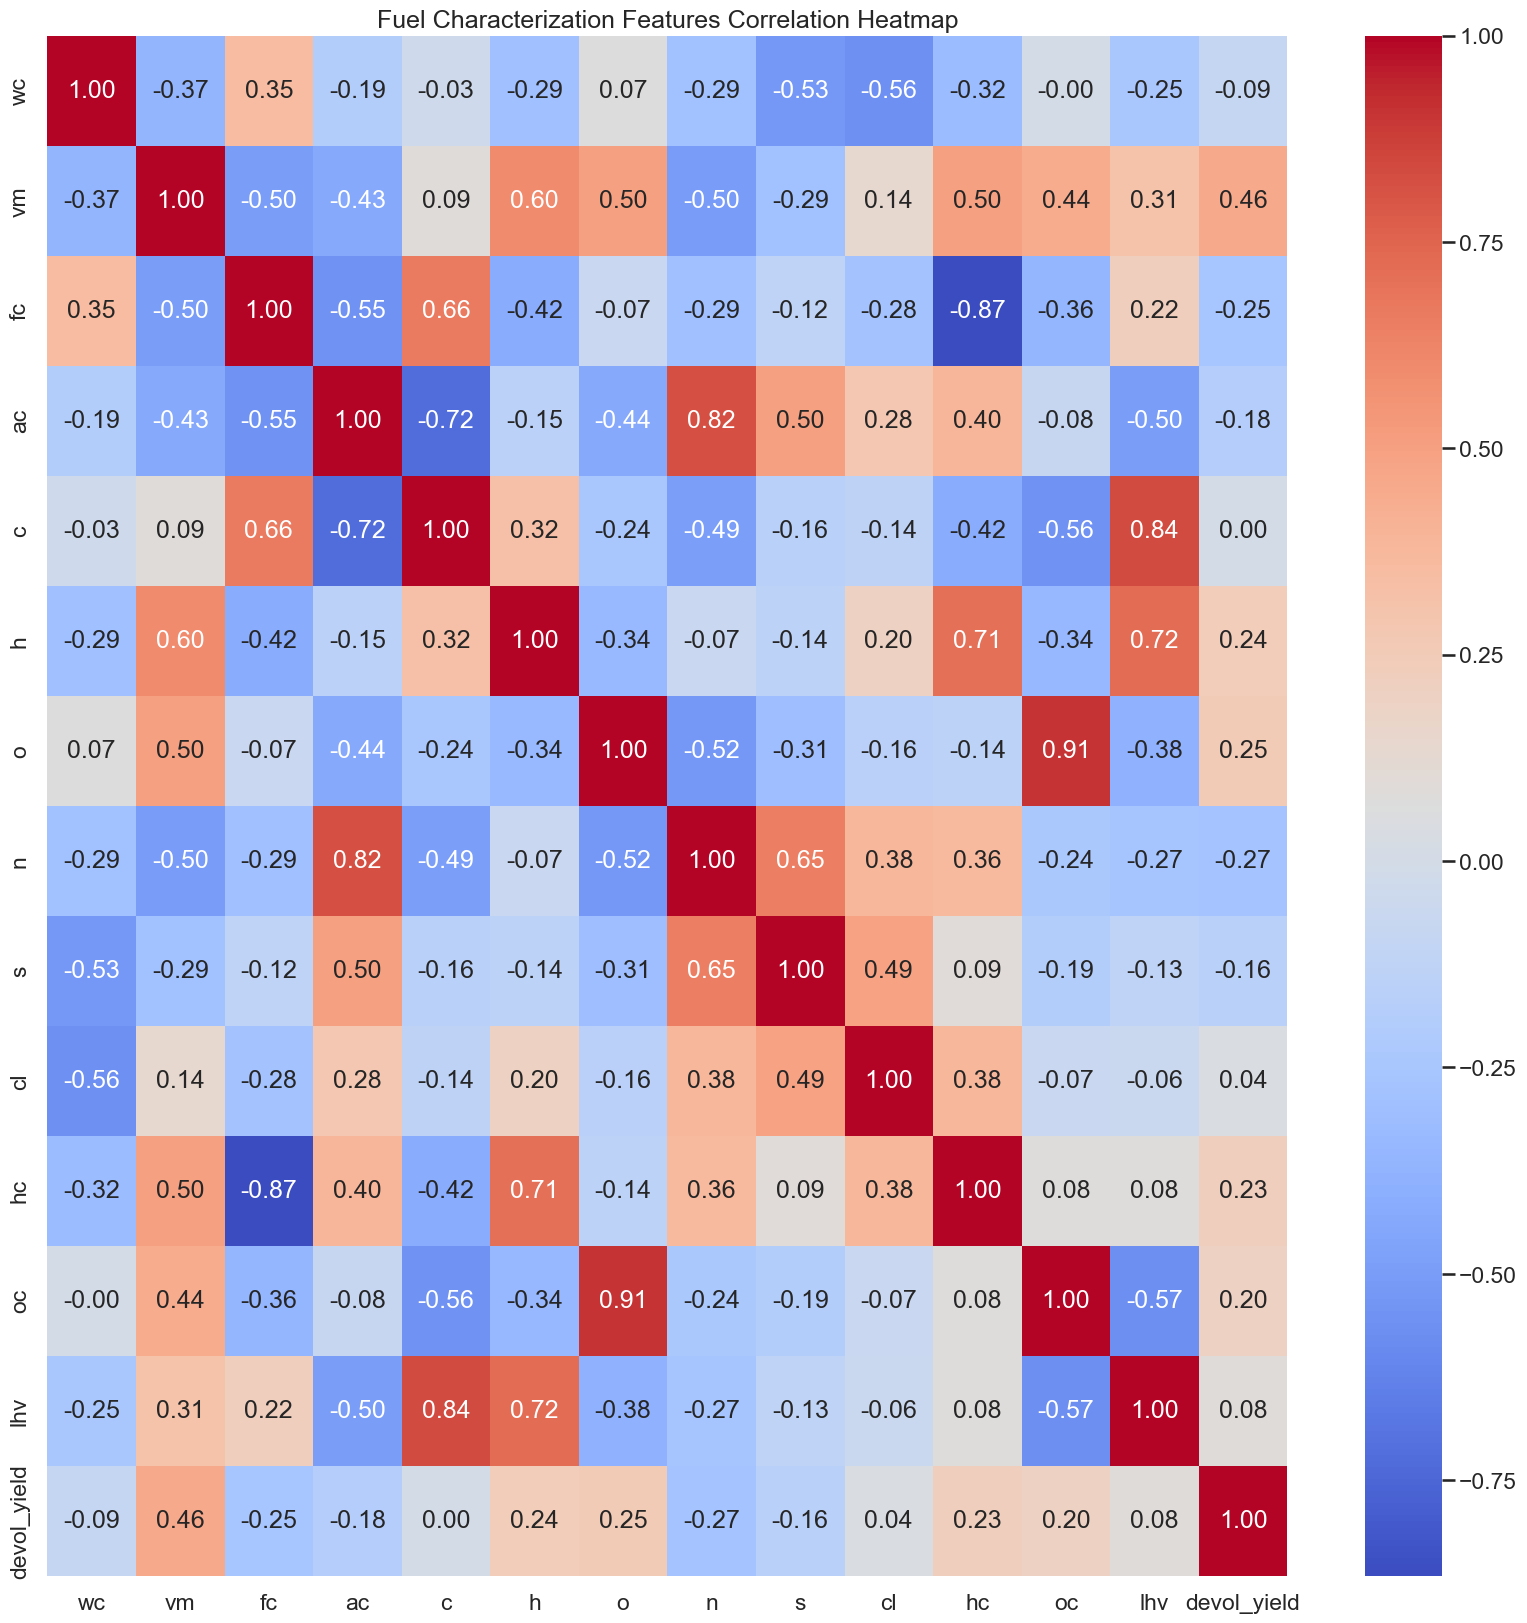

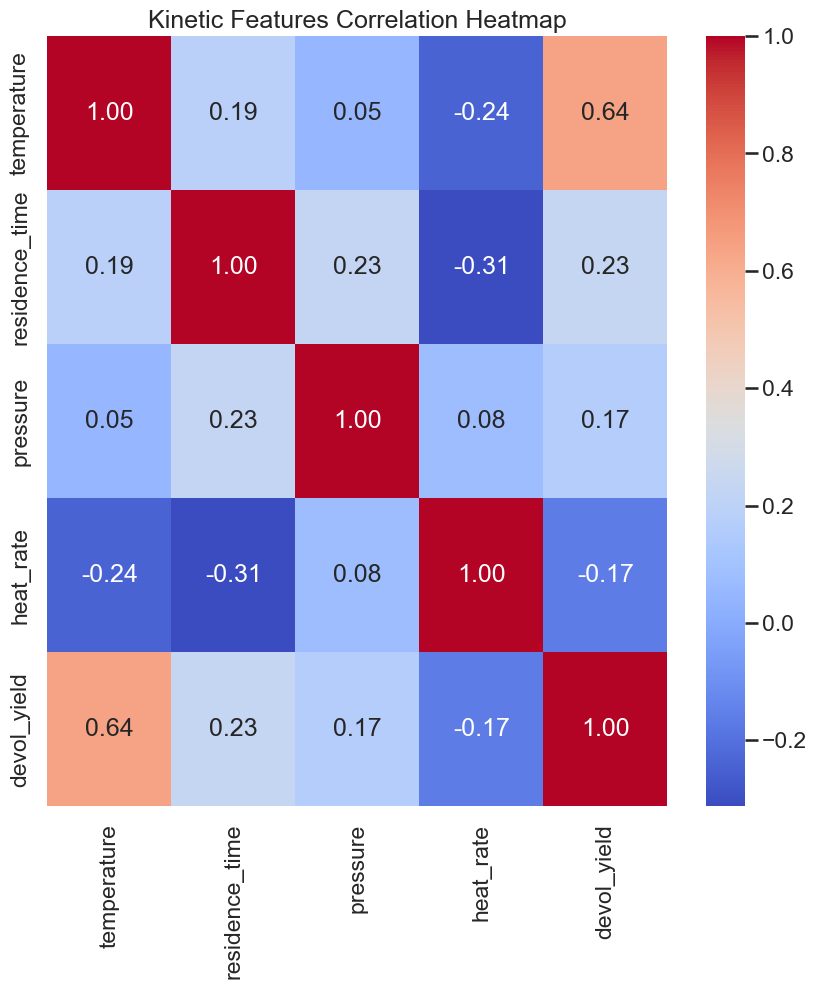

In [1757]:
biomass_corr_matrix = biomass_filtered.drop(['sample', 'fuel_category','fuel_type', 'temperature', 'pressure', 'heat_rate', 'residence_time'], axis=1).corr()
biomass_corr_matrix_kin = biomass_filtered.drop(['sample', 'fuel_category','fuel_type', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv'], axis=1).corr()
mix_corr_matrix = mix_filtered.drop(['sample', 'fuel_category','fuel_type', 'temperature', 'pressure', 'heat_rate', 'residence_time'], axis=1).corr()
coal_corr_matrix = coal_filtered.drop(['sample', 'fuel_category','fuel_type'], axis=1).corr()
plastic_corr_matrix = plastic_filtered.drop(['sample', 'fuel_category','fuel_type'], axis=1).corr()

total_corr_matrix = filtered_features.drop(['sample', 'fuel_category','fuel_type', 'temperature', 'pressure', 'heat_rate', 'residence_time'], axis=1).corr()
total_corr_matrix_kin = filtered_features.drop(['sample', 'fuel_category','fuel_type', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv'], axis=1).corr()

devol_yield = pd.concat([biomass_corr_matrix.iloc[-1], mix_corr_matrix.iloc[-1], coal_corr_matrix.iloc[-1], plastic_corr_matrix.iloc[-1]],  axis = 1)


plt.figure(figsize=(20, 20))
sns.heatmap(total_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Fuel Characterization Features Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(total_corr_matrix_kin, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Kinetic Features Correlation Heatmap")
plt.show()



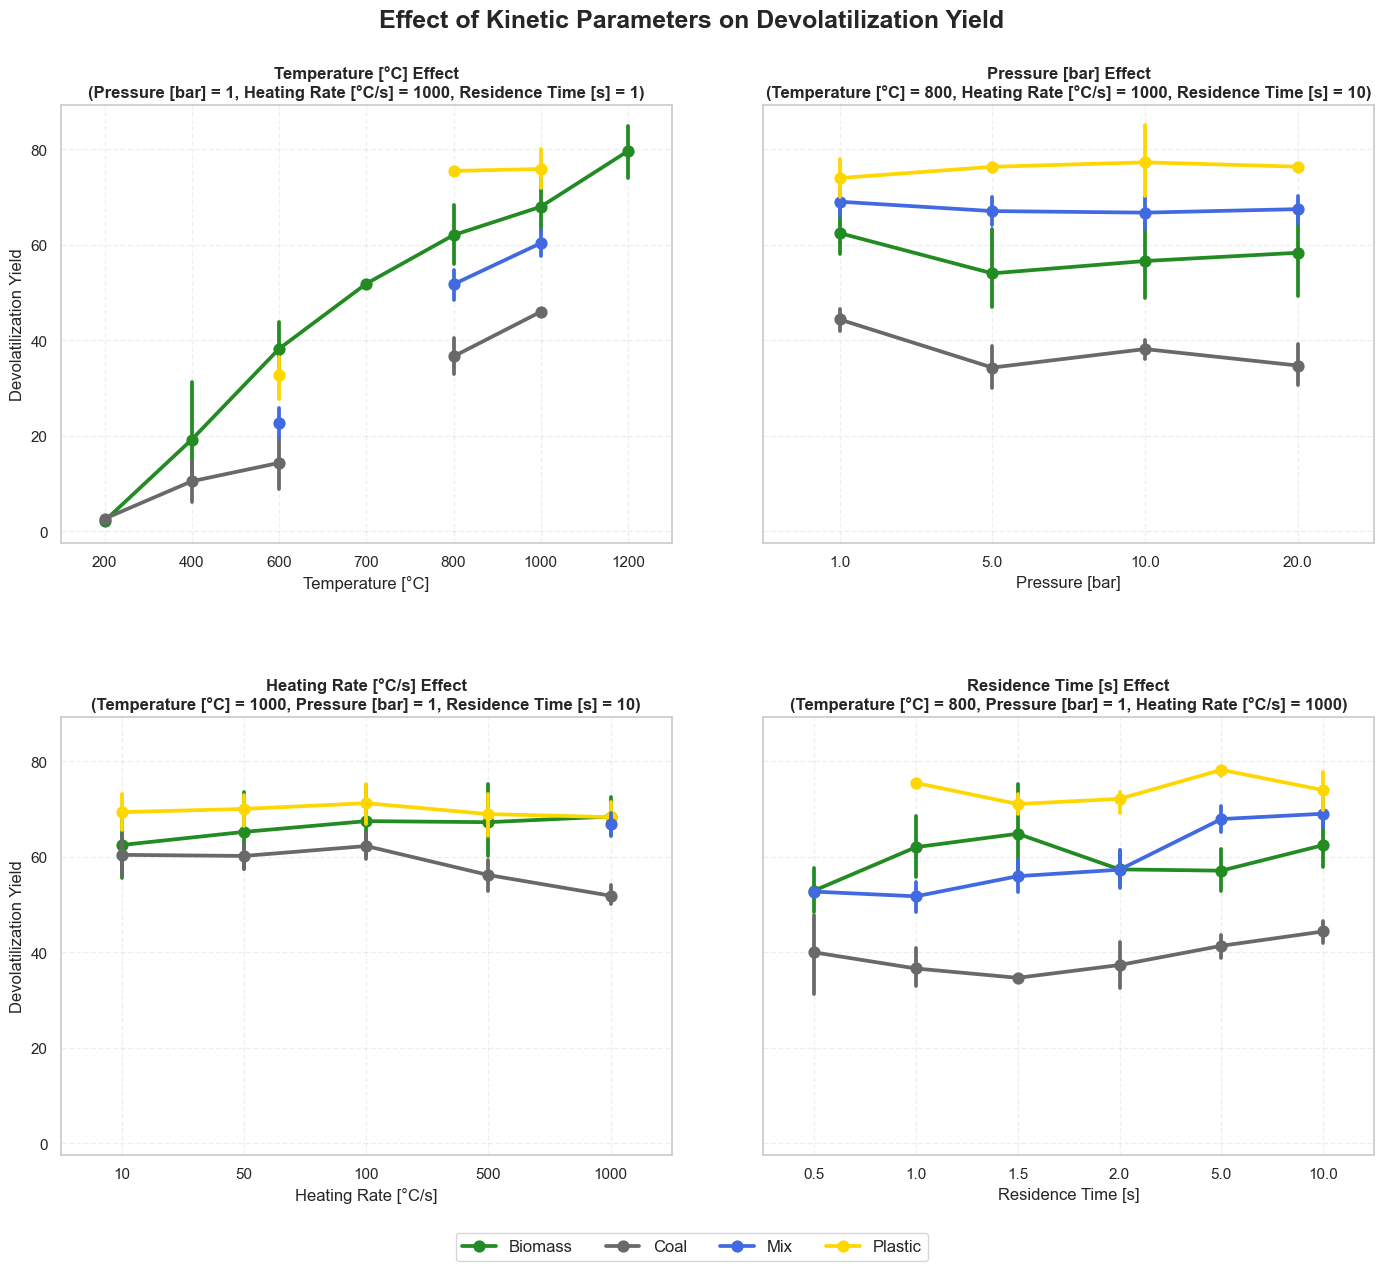

In [1758]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define kinetic parameters
parameters = ['temperature', 'pressure', 'heat_rate', 'residence_time']

# Define fixed conditions to isolate each parameter
fixed_conditions = {
    'temperature': {'pressure': 1, 'heat_rate': 1000, 'residence_time': 1},
    'pressure': {'temperature': 800, 'heat_rate': 1000, 'residence_time': 10},
    'heat_rate': {'temperature': 1000, 'pressure': 1, 'residence_time': 10},
    'residence_time': {'temperature': 800, 'pressure': 1, 'heat_rate': 1000},
}

custom_palette = {
    'Coal': 'dimgray',        # dark grey
    'Plastic': 'gold',        # yellow
    'Biomass': 'forestgreen', # green
    'Mix': 'royalblue'        # blue
}


# Display names for titles and axes
param_display_names = {
    'temperature': 'Temperature [°C]',
    'pressure': 'Pressure [bar]',
    'heat_rate': 'Heating Rate [°C/s]',
    'residence_time': 'Residence Time [s]'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharey=True)

# Flatten axes for easy indexing
axs = axs.flatten()

# Loop over each parameter and plot
for idx, param in enumerate(parameters):
    ax = axs[idx]

    # Filter based on fixed conditions
    condition = pd.Series(True, index=filtered_features.index)
    for other_param, val in fixed_conditions[param].items():
        condition &= (filtered_features[other_param] == val)

    subset = filtered_features[condition]

    # Skip if not enough variation
    if subset[param].nunique() <= 1:
        ax.set_visible(False)
        continue

    # Create pointplot
    sns.pointplot(
        data=subset,
        x=param,
        y='devol_yield',
        hue='fuel_category',
        ax=ax,
        markers='o',
        linestyles='-',
        palette=custom_palette
    )

    # Formatting
    # Dynamically build the subtitle from fixed conditions
    # Dynamically build the subtitle from fixed conditions using full display names
    subtitle_parts = []
    for k, v in fixed_conditions[param].items():
        display_name = param_display_names[k]
        subtitle_parts.append(f"{display_name} = {v}")
    subtitle = ", ".join(subtitle_parts)

    ax.set_title(f'{param_display_names[param]} Effect\n({subtitle})', fontsize=12, fontweight='bold')


    ax.set_xlabel(param_display_names[param], fontsize=12)
    ax.set_ylabel('Devolatilization Yield', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.get_legend().remove()

# Remove unused subplot if any
if len(parameters) < len(axs):
    for k in range(len(parameters), len(axs)):
        axs[k].set_visible(False)

# Main title
plt.suptitle('Effect of Kinetic Parameters on Devolatilization Yield',
             fontsize=18, fontweight='bold', y=1.01)

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.15)

# Legend outside
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=len(labels), frameon=True, fontsize=12)

plt.show()


In [1759]:
'''import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure temperature is numeric
filtered_features['temperature'] = pd.to_numeric(filtered_features['temperature'], errors='coerce')
filtered_features = filtered_features[
    (filtered_features['pressure'] == 1) &
    (filtered_features['heat_rate'] == 1000) &
    (filtered_features['residence_time'] == 1) &
    (filtered_features['temperature'] != 700)
].dropna(subset=['temperature'])

# Sort and bin O:C
filtered_features = filtered_features.sort_values('temperature')
hc_bins = pd.qcut(filtered_features['hc'], q=3, labels=['Low H:C', 'Medium H:C', 'High H:C'])
filtered_features['HC_group'] = hc_bins

# Create a categorical string label for temperature to increase x spacing
filtered_features['temp_label'] = filtered_features['temperature'].astype(int).astype(str) + '°C'

# Define consistent palette
palette = {"High H:C": "#6495ED", "Medium H:C": "#50C878", "Low H:C": "#C3B1E1"}

# Grouped mean for trendlines
mean_trend = filtered_features.groupby(['temperature', 'HC_group'])['devol_yield'].mean().reset_index()
mean_trend['temp_label'] = mean_trend['temperature'].astype(int).astype(str) + '°C'

# 1️⃣ Boxplot with increased spacing
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=filtered_features,
    x='temp_label',
    y='devol_yield',
    hue='HC_group',
    dodge=1.5,              # Controls how far apart groups are
    fliersize=0,
    palette=palette,
    width=0.3, linecolor='black'               # Reduce box width to allow more spacing
)
plt.title('Distribution of Volatile Yield by Temperature and H:C Ratio', fontsize=15, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Volatile Yield (%)', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 2️⃣ Trend lines with mean points
plt.figure(figsize=(14, 6))
for hc_group in mean_trend['HC_group'].unique():
    group_data = mean_trend[mean_trend['HC_group'] == hc_group]
    plt.plot(group_data['temperature'], group_data['devol_yield'],
             marker='o', linewidth=3, label=hc_group, color=palette[hc_group])
plt.title('Mean Volatile Yield vs Temperature by H:C Ratio', fontsize=15, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Mean Volatile Yield (%)', fontsize=12)
plt.xticks(sorted(filtered_features['temperature'].unique()),
           [str(int(t)) + '°C' for t in sorted(filtered_features['temperature'].unique())],
           rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()'''


'import seaborn as sns\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure temperature is numeric\nfiltered_features[\'temperature\'] = pd.to_numeric(filtered_features[\'temperature\'], errors=\'coerce\')\nfiltered_features = filtered_features[\n    (filtered_features[\'pressure\'] == 1) &\n    (filtered_features[\'heat_rate\'] == 1000) &\n    (filtered_features[\'residence_time\'] == 1) &\n    (filtered_features[\'temperature\'] != 700)\n].dropna(subset=[\'temperature\'])\n\n# Sort and bin O:C\nfiltered_features = filtered_features.sort_values(\'temperature\')\nhc_bins = pd.qcut(filtered_features[\'hc\'], q=3, labels=[\'Low H:C\', \'Medium H:C\', \'High H:C\'])\nfiltered_features[\'HC_group\'] = hc_bins\n\n# Create a categorical string label for temperature to increase x spacing\nfiltered_features[\'temp_label\'] = filtered_features[\'temperature\'].astype(int).astype(str) + \'°C\'\n\n# Define consistent palette\npalette = {"High H:C": "#6495ED", "Med

In [1760]:
'''import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure temperature is numeric
filtered_features['temperature'] = pd.to_numeric(filtered_features['temperature'], errors='coerce')
filtered_features = filtered_features[
    (filtered_features['pressure'] == 1) &
    (filtered_features['heat_rate'] == 1000) &
    (filtered_features['residence_time'] == 1) &
    (filtered_features['temperature'] != 700)
].dropna(subset=['temperature'])

# Sort and bin O:C
filtered_features = filtered_features.sort_values('temperature')
oc_bins = pd.qcut(filtered_features['oc'], q=3, labels=['Low O:C', 'Medium O:C', 'High O:C'])
filtered_features['OC_group'] = oc_bins

# Create a categorical string label for temperature to increase x spacing
filtered_features['temp_label'] = filtered_features['temperature'].astype(int).astype(str) + '°C'

# Define consistent palette
palette = {"High O:C": "#6495ED", "Medium O:C": "#50C878", "Low O:C": "#C3B1E1"}

# Grouped mean for trendlines
mean_trend = filtered_features.groupby(['temperature', 'OC_group'])['devol_yield'].mean().reset_index()
mean_trend['temp_label'] = mean_trend['temperature'].astype(int).astype(str) + '°C'

# 1️⃣ Boxplot with increased spacing
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=filtered_features,
    x='temp_label',
    y='devol_yield',
    hue='OC_group',
    dodge=1.5,              # Controls how far apart groups are
    fliersize=0,
    palette=palette,
    width=0.3, linecolor='black'               # Reduce box width to allow more spacing
)
plt.title('Distribution of Volatile Yield by Temperature and O:C Ratio', fontsize=15, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Volatile Yield (%)', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 2️⃣ Trend lines with mean points
plt.figure(figsize=(14, 6))
for oc_group in mean_trend['OC_group'].unique():
    group_data = mean_trend[mean_trend['OC_group'] == oc_group]
    plt.plot(group_data['temperature'], group_data['devol_yield'],
             marker='o', linewidth=3, label=oc_group, color=palette[oc_group])
plt.title('Mean Volatile Yield vs Temperature by O:C Ratio', fontsize=15, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Mean Volatile Yield (%)', fontsize=12)
plt.xticks(sorted(filtered_features['temperature'].unique()),
           [str(int(t)) + '°C' for t in sorted(filtered_features['temperature'].unique())],
           rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()'''


'import seaborn as sns\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure temperature is numeric\nfiltered_features[\'temperature\'] = pd.to_numeric(filtered_features[\'temperature\'], errors=\'coerce\')\nfiltered_features = filtered_features[\n    (filtered_features[\'pressure\'] == 1) &\n    (filtered_features[\'heat_rate\'] == 1000) &\n    (filtered_features[\'residence_time\'] == 1) &\n    (filtered_features[\'temperature\'] != 700)\n].dropna(subset=[\'temperature\'])\n\n# Sort and bin O:C\nfiltered_features = filtered_features.sort_values(\'temperature\')\noc_bins = pd.qcut(filtered_features[\'oc\'], q=3, labels=[\'Low O:C\', \'Medium O:C\', \'High O:C\'])\nfiltered_features[\'OC_group\'] = oc_bins\n\n# Create a categorical string label for temperature to increase x spacing\nfiltered_features[\'temp_label\'] = filtered_features[\'temperature\'].astype(int).astype(str) + \'°C\'\n\n# Define consistent palette\npalette = {"High O:C": "#6495ED", "Med

In [1761]:
#filtered_features.groupby('OC_group')['oc'].describe()


In [1762]:
#filtered_features.groupby('HC_group')['hc'].describe()


In [1763]:
# One-hot encode
filtered_features_ohe = pd.get_dummies(filtered_features, columns=['fuel_category'], drop_first=False)

# Convert only the new OHE columns to int
ohe_cols = [col for col in filtered_features_ohe.columns if col.startswith('fuel_category_')]
filtered_features_ohe[ohe_cols] = filtered_features_ohe[ohe_cols].astype(int)


In [1764]:
filtered_features_ohe.columns

Index(['sample', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate',
       'fuel_type', 'devol_yield', 'fuel_category_Biomass',
       'fuel_category_Coal', 'fuel_category_Mix', 'fuel_category_Plastic'],
      dtype='object')

In [1765]:
filtered_features_ohe.head()

,sample,wc,vm,fc,ac,c,h,o,n,s,...,temperature,residence_time,pressure,heat_rate,fuel_type,devol_yield,fuel_category_Biomass,fuel_category_Coal,fuel_category_Mix,fuel_category_Plastic
1571,cel_18,5.725,87.9005,6.3745,0.00,40.305405,4.51767,54.860844,0.269662,0.04642,...,200,1.0,1.0,1000,Cellulose,2.018886,1,0,0,0
1572,cel_19,5.725,87.9005,6.3745,0.00,40.305405,4.51767,54.860844,0.269662,0.04642,...,200,1.0,1.0,1000,Cellulose,2.324709,1,0,0,0
1437,htc_1,7.345,48.2400,6.9000,37.52,33.085000,3.26500,16.600000,1.877000,0.34200,...,200,0.5,1.0,1000,HTC-MSW,17.427386,1,0,0,0
1438,htc_9,7.345,48.2400,6.9000,37.52,33.085000,3.26500,16.600000,1.877000,0.34200,...,200,0.5,1.0,1000,HTC-MSW,11.277050,1,0,0,0
1439,htc_15,7.345,48.2400,6.9000,37.52,33.085000,3.26500,16.600000,1.877000,0.34200,...,200,0.5,1.0,1000,HTC-MSW,16.384181,1,0,0,0


In [1766]:
filtered_features_ohe.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv", index=False)


In [1767]:
filtered_features_ohe.describe()

,wc,vm,fc,ac,c,h,o,n,s,cl,...,lhv,temperature,residence_time,pressure,heat_rate,devol_yield,fuel_category_Biomass,fuel_category_Coal,fuel_category_Mix,fuel_category_Plastic
count,1550.000000,1550.000000,1550.000000,1550.00000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,...,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,6.684194,60.906397,17.215947,15.46952,50.255519,5.852045,20.413719,1.693145,0.516425,0.381678,...,20.825146,795.561290,5.613871,2.350000,907.232258,53.327615,0.481935,0.145806,0.256774,0.115484
std,2.347552,12.213044,12.064477,12.11506,12.203855,1.962676,10.138436,1.031794,0.657600,0.681485,...,5.595025,201.074682,4.271050,3.942811,271.889387,21.358524,0.499835,0.353026,0.436995,0.319708
min,2.600000,44.200000,3.064326,0.00000,32.400000,3.265000,7.000000,0.269662,0.046420,0.000000,...,13.528000,200.000000,0.500000,0.500000,10.000000,0.974163,0.000000,0.000000,0.000000,0.000000
25%,5.200000,50.700000,7.854000,4.20000,37.500000,4.600000,15.400000,0.900000,0.150000,0.000000,...,15.055000,600.000000,1.500000,1.000000,1000.000000,40.979002,0.000000,0.000000,0.000000,0.000000
50%,5.810000,59.392995,15.080040,13.60000,50.400000,4.910000,16.600000,1.832640,0.200000,0.000000,...,19.843000,800.000000,5.000000,1.000000,1000.000000,55.142216,0.000000,0.000000,0.000000,0.000000
75%,7.752000,72.700000,16.400000,23.70000,58.400883,7.000000,21.200000,2.210000,0.500000,0.100000,...,23.181040,1000.000000,10.000000,1.000000,1000.000000,68.031315,1.000000,0.000000,1.000000,0.000000
max,10.800000,91.735674,44.500000,37.52000,82.300000,10.132050,54.936839,3.900000,2.500000,1.800000,...,35.800000,1200.000000,20.000000,20.000000,1000.000000,99.756944,1.000000,1.000000,1.000000,1.000000


In [1768]:
feature_cols = [
    'h', 'wc', 'vm', 'ac', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'fc', 'temperature', 'residence_time', 'pressure', 'heat_rate'
]

# These are your original min and max values (as from your summary)
min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402, 'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000
}

# Optional: define a margin (e.g. 10%)
margin_ratio = 0.4

# Create expanded bounds
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = min_val - range_val * margin_ratio
    if new_min < 0:
        new_min = 0
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

# View the expanded bounds
for feat, bounds in expanded_bounds.items():
    print(f"{feat}: {bounds}")


h: (0.518, 12.879)
wc: (0, 14.08)
vm: (25.186, 110.75)
ac: (0, 52.528)
c: (12.44, 102.26)
lhv: (4.619, 44.709)
o: (0, 74.112)
n: (0, 5.352)
s: (0, 3.481)
cl: (0, 2.1)
hc: (0.237, 2.32)
oc: (0, 1.462)
fc: (0, 61.074)
temperature: (0, 1600.0)
residence_time: (0, 27.8)
pressure: (0, 27.8)
heat_rate: (0, 1396.0)


In [1769]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Drop columns not used for VIF calculation
X = filtered_features.drop(columns=['sample', 'devol_yield', 'fuel_category', 'fuel_type'])

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
4,c,5373.461658
1,vm,3680.597198
10,hc,3169.702315
5,h,2135.095370
12,lhv,917.259003
6,o,585.037285
2,fc,461.695659
11,oc,209.257822
7,n,172.168362
0,wc,109.551210
